In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from hj_mad_ls import HJ_MD_LS

# Hyperparameters
n_neurons = 50  # Number of neurons in the shallow network
learning_rate = 0.01
num_epochs = 1000
batch_size = 100

# Generate data
no_of_samples = 500
noise_level = 1e-3
x = np.linspace(0, 2 * np.pi, no_of_samples)
y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the shallow neural network
class ShallowNet(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowNet, self).__init__()
        self.linear = nn.Linear(1, n_neurons)
        self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)      # Compute w_j * x + b_j
        x = self.relu(x)        # Apply ReLU activation
        x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
        return x

    def set_parameters(self, parameters):
        """
        Set model parameters from the flattened parameter vector.
        This method updates the model's parameters from a single flattened tensor.
        """
        offset = 0
        for param in parameters:
            param_size = param.numel() 
            # if param_size.len() == 1:
            #new_param_values = parameters[0, offset:offset + param_size]
            # else:
            new_param_values = parameters[offset:offset + param_size]
            new_param_values = new_param_values.view(param.shape)  
            param.data.copy_(new_param_values)  
            offset += param_size  


# Initialize model, loss function, and optimizer
model = ShallowNet(n_neurons)
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# HJ_MAD hyperparameters
delta = 0.1
t = 1
int_samples = int(10)
max_iters = int(1e2)
f_tol = 1e-5
sat_tol = 1e-5
delta_dampener=0.8
beta=0.1

# Use HJ_MAD to optimize the model parameters
HJ_MAD_alg = HJ_MD_LS(delta=delta, t=t, int_samples=int_samples, max_iters=max_iters, f_tol=f_tol,sat_tol=sat_tol,delta_dampener=delta_dampener,beta=beta,verbose=True)

# Define the function f (e.g., a loss function based on the model's predictions)
def Objective_function(x, model, inputs, targets):
    '''
    Input:
        - tensor x is of shape (samples, n_features)
    Output:
        - loss values tensor of shape (samples, 1)
    '''
    n_features = x.shape[1]
    n_samples = x.shape[0]
    
    # Initialize the list to store individual sample losses
    sample_losses = []

    # Loop over each sample and compute the loss
    for i in range(n_samples):
        # Extract model parameters for the current sample (flattened)
        model_params = x[i, :]  # Take the i-th sample from the flattened parameter vector
        
        # Set the model parameters using the current flattened parameters
        model.set_parameters(model_params)  # Set the model parameters
        
        # Forward pass: Get the output of the model for the given inputs
        outputs = model(inputs)#[i:i+1])  # Take a single input for each sample
        
        # Calculate the loss for the current sample
        loss = criterion(outputs, targets)#[i:i+1])  # Calculate the loss for the i-th sample
        
        # Store the loss for the current sample
        sample_losses.append(loss.item())  # Append loss to list
    
    # Convert the list of sample losses to a tensor and return
    return torch.tensor(sample_losses).view(-1, 1)

# Training loop: Iterate through the epochs
for epoch in range(num_epochs):
    # Iterate through the dataset in batches
    for inputs, targets in dataloader:
        # Define f
        def f(x):
            return Objective_function(x, model, inputs, targets)
        
        # Get the model parameters as a flattened tensor
        parameters = list(model.parameters())
        parameter_vector = torch.cat([param.flatten() for param in parameters])
        parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

        # Compute Current Loss
        loss_old = f(parameter_vector)  # Compute the loss for the current parameters

        # Run HJ_MAD to optimize the model parameters
        new_parameters, loss, iterations = HJ_MAD_alg.run(f, parameter_vector)  # Run HJ_MAD to optimize the model parameters

        # Update the model parameters with the optimized values
        model.set_parameters(new_parameters)

        # Print the loss before and after optimization
        print(f'Loss before: {loss_old.item():.4f} | Loss after: {loss.item():.4f} | Iterations: {iterations}')
        
    # Print the loss every 100 epochs for monitoring
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()

-------------------------- RUNNING HJ-MAD-LS Algorithm ---------------------------
dimension =  150 n_samples =  10
[  0]: fk = 8.79e+01 | delta = 1.00e-01
    Samples taken into account by softmax: 1
    f(prox): 32.724586486816406 | f(xk): 87.90498352050781
    No improvement from line search | f(prox_ls): tensor([[54.8676]])
[  1]: fk = 2.17e+01 | delta = 1.00e-01
    Samples taken into account by softmax: 3
    f(prox): 2.495229959487915 | f(xk): 21.703598022460938
    No improvement from line search | f(prox_ls): tensor([[9.4499]])
[  2]: fk = 2.75e+00 | delta = 1.00e-01
    Samples taken into account by softmax: 5
    f(prox): 0.5520502328872681 | f(xk): 2.7520530223846436
    No improvement from line search | f(prox_ls): tensor([[1.0807]])
[  3]: fk = 1.33e+00 | delta = 1.00e-01
    Samples taken into account by softmax: 2
    f(prox): 0.636005699634552 | f(xk): 1.3287668228149414
    No improvement from line search | f(prox_ls): tensor([[1.0793]])
[  4]: fk = 3.71e-01 | delta =

KeyboardInterrupt: 

Epoch [100/1000], Loss: 0.0130
Epoch [200/1000], Loss: 0.0031
Epoch [300/1000], Loss: 0.0014
Epoch [400/1000], Loss: 0.0024
Epoch [500/1000], Loss: 0.0007
Epoch [600/1000], Loss: 0.0029
Epoch [700/1000], Loss: 0.0159
Epoch [800/1000], Loss: 0.0010
Epoch [900/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0010


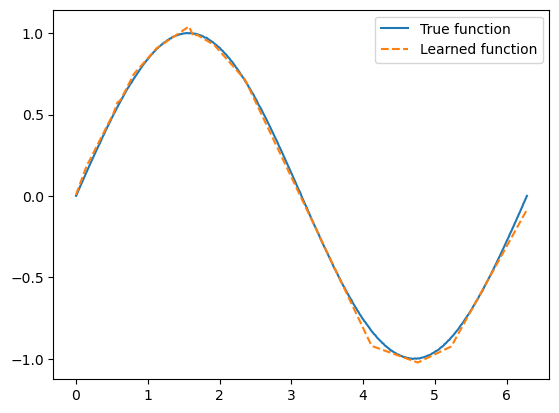

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
n_neurons = 50  # Number of neurons in the shallow network
learning_rate = 0.01
num_epochs = 1000
batch_size = 100

# Generate data
no_of_samples = 500
noise_level = 1e-3
x = np.linspace(0, 2 * np.pi, no_of_samples)
y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the shallow neural network
class ShallowNet(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowNet, self).__init__()
        self.linear = nn.Linear(1, n_neurons)
        self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)      # Compute w_j * x + b_j
        x = self.relu(x)        # Apply ReLU activation
        x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
        return x

# Initialize model, loss function, and optimizer
model = ShallowNet(n_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()